In [253]:
feat_names = ["tum_loc", "side_of_tum_epicenter", "eloq_brain", "enh_quality", "prop_enh", "prop_ncet", "prop_necr", "cysts", "mf_or_mc", "t1_f_ratio", "thick_em", "def_em", "def_nem", "prop_edema", "edema_crosses_ml", "hem", "diff", "pial_inv", "epe_inv", "cort_involv", "deep_wm_inv", "ncet_crosses_ml", "enh_tum_crosses_ml", "satellites", "calv_remodel", "ext_res_enh_tum", "ext_res_ncet", "ext_res_vas_edema", "les_size1", "les_size2"]
feat_mapping = dict(zip(["f%d" % i for i in range(1, 31)], feat_names))

categorical_cols = [1, 2, 3, 4, 9, 10, 11, 12, 13, 17]
yes_no_cols = [8, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25]
cm_cols = [29, 30]
percent_cols = [5, 6, 7, 14, 26, 27, 28] 

class Utils():    
    def show_dcm(pixel_array):
        plt.imshow(pixel_array, cmap = plt.get_cmap("bone"))
        
    def dcm_downsample(pixel_array, interval):
        return pixel_array[::interval, ::interval]
    

def union_categorical_features(series):

    as_int_tups = []
    for categories in series.tolist():
        if type(categories) == str:
            as_int_tups.append(map(int, re.findall(r"\d+", categories)))
        else:
            as_int_tups.append([categories])
        
    as_int_sets = [set(tup) for tup in as_int_tups]
    return tuple(ft.reduce(lambda x, y: x.union(y), as_int_sets))

def mri_group_categorical_feats(group_df):
    regrouping = {}
    categorical_feats = ["f%d" % d for d in categorical_cols]
    
    for feat in categorical_feats:
        regrouping[feat] = union_categorical_features(group_df[feat])
        
    return pd.Series(regrouping, index=categorical_feats)

In [254]:
import pydicom
import numpy
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import functools as ft
import re

REMBRANDT_PATH = "REMBRANDT/"
CLINICAL_DATA_PATH = "clinical_2014-01-16.xlsx"
MRI_FEATURE_PATH = "VASARI_MRI_features (gmdi - wiki).xls"

In [255]:
clinical_df = pd.read_excel(CLINICAL_DATA_PATH)
mri_df = pd.read_excel(MRI_FEATURE_PATH)

In [256]:
mri_df = mri_df.groupby("GMDI").apply(mri_group_categorical_feats)

In [257]:
clinical_df = clinical_df.rename(columns={'Sample':'GMDI'})
mri_df = mri_df.rename_axis("GMDI").reset_index()

In [258]:
df = pd.merge(clinical_df, mri_df, how="inner", on="GMDI")

In [269]:
df["GMDI"] = df["GMDI"].str.replace("_","-")

In [271]:
dcm_paths = []
for patient_id in df["GMDI"]:
    dcm_paths += glob.glob(REMBRANDT_PATH + "%s/*/*/*.dcm" % patient_id)
print("Remaining DCM Images", len(dcm_paths))

Remaining DCM Images 21223


In [274]:
ds[0x10, 0x10].value

'253609'

In [98]:
print(ds.keys)

<bound method Dataset.keys of (0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'OTHER']
(0008, 0016) SOP Class UID                       UI: MR Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.9328.50.50.137794963200945105797570030744217446742
(0008, 0020) Study Date                          DA: '20050619'
(0008, 0023) Content Date                        DA: '20050619'
(0008, 0030) Study Time                          TM: ''
(0008, 0033) Content Time                        TM: ''
(0008, 0050) Accession Number                    SH: '1293190500624970'
(0008, 0060) Modality                            CS: 'MR'
(0008, 0070) Manufacturer                        LO: ''
(0008, 0090) Referring Physician's Name          PN: ' '
(0008, 1032)  Procedure Code Sequence   1 item(s) ---- 

   ---------
(0010, 0010) Patient's Name                      PN: '253609'
(0010, 0020) Pati

(256, 256)

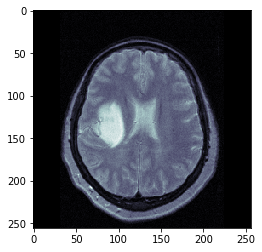

In [87]:
downsampled_data = Utils.dcm_downsample(data, 2)
Utils.show_dcm(downsampled_data)
downsampled_data.shape

The downsampled image has 64 x 64 voxels
The information of the data set after downsampling: 

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'OTHER']
(0008, 0016) SOP Class UID                       UI: MR Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.9328.50.50.137794963200945105797570030744217446742
(0008, 0020) Study Date                          DA: '20050619'
(0008, 0023) Content Date                        DA: '20050619'
(0008, 0030) Study Time                          TM: ''
(0008, 0033) Content Time                        TM: ''
(0008, 0050) Accession Number                    SH: '1293190500624970'
(0008, 0060) Modality                            CS: 'MR'
(0008, 0070) Manufacturer                        LO: ''
(0008, 0090) Referring Physician's Name          PN: ' '
(0008, 1032)  Procedure Code Sequence   1 item(s) ---- 

   ---------
(0010, 0010) P

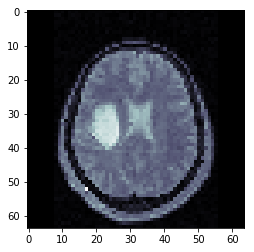

In [73]:
data = ds.pixel_array

data_downsampling = data[::8, ::8]
print('The downsampled image has {} x {} voxels'.format(
    data_downsampling.shape[0], data_downsampling.shape[1]))

# copy the data back to the original data set
ds.PixelData = data_downsampling.tobytes()
# update the information regarding the shape of the data array
ds.Rows, ds.Columns = data_downsampling.shape

# print the image information given in the dataset
print('The information of the data set after downsampling: \n')
print(ds)
Utils.show_dcm(ds.pixel_array)